# Visualising the CO2 Emission

## Introduction

#### This notebook performs exploratory data analysis on multiple datasets and visualises the consolidated data.

The main objective is to visualise COVID-19 vaccination process globally and monitor its progress.

Plotly is used to visualise the data.

#### Used datasets are:

- CO2_GHG_emissions-data
- Country Mapping - ISO, Continent, Region
- Population by Country - 2020

#### Visualisations answer some simple questions:

- How has CO2 release been changed since the year 1750?
- What are the countries and regions causing most CO2 release?
- Is there a correlation between a country's CO2 emission and its population?

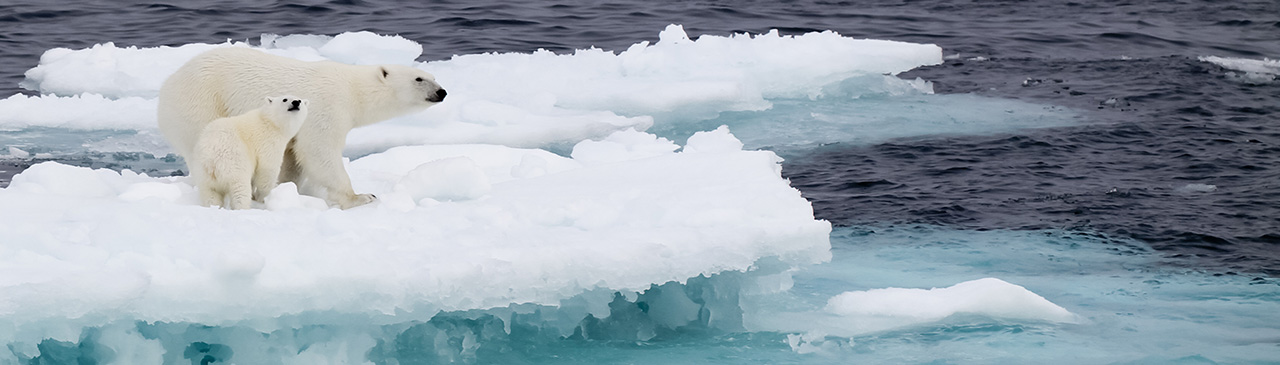

## 1. Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import math
import cufflinks as cf
import plotly
import plotly.express as px
import plotly.graph_objects as go
%matplotlib inline

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
init_notebook_mode(connected=True)
cf.go_offline()

## 2. Data Manipulation on the CO2 Emission Dataset

### Read the CO2 data frame with necessary columns & parsing the date column

In [ ]:
df_co = pd.read_csv('../input/co2-ghg-emissionsdata/co2_emission.csv', parse_dates = ['Year'])

### Inspect the CO2 emission data frame

In [ ]:
df_co.info()

### See which rows do not have ISO Code

In [ ]:
df_co_na = df_co[df_co['Code'].isnull()]

df_co_na['Entity'].unique()

#### It looks like there are only two countries, which don't have their ISO ALPHA-3 code missing. They are Kyrgysztan and Wallis and Futuna Islands. We will add their codes, KGZ and WLF manually.

### Filling missing code values

In [ ]:
# Create new data frames for Kyrgysztan and Wallis and Futuna Islands and fill their Code column with their codes

df_kgz = df_co[df_co["Entity"].isin(["Kyrgysztan"])]
df_kgz.fillna('KGZ', inplace = True)

df_wlf = df_co[df_co["Entity"].isin(["Wallis and Futuna Islands"])]
df_wlf.fillna('WLF', inplace = True)

### Now, drop all rows containing NaN in their Code column
#### There is no problem with dropping Kyrgysztan and Wallis and Futuna Islands rows since we are going to append their data frames to the main one.

In [ ]:
# Drop the rows containing NaN values in their Code column (including the )
# Since Code column is the only column containing NaN, we can directly apply dropna method

df_co.dropna(inplace=True)
df_co.info()

### Append all three data frames together to have the final country dataframe

In [ ]:
# Append all 3 data frames
df = pd.concat([df_co, df_kgz, df_wlf])

# Sort values by Country
df.sort_values(['Entity', 'Year'])

df.reset_index(level=0, inplace=True)

del df["index"]

df.head()

### To get the region names for the countries, read the Country Codes dataset into a dataframe

In [ ]:
# Read the dataset into a data frame
df_inf = pd.read_csv('../input/country-mapping-iso-continent-region/continents2.csv', usecols=["alpha-3", "region", "sub-region"])

# Rename the column of data frame
df_inf.rename(columns={'alpha-3':'Code', 'region':'Region', 'sub-region':'Sub-Region'}, inplace=True)

# Have a look at the data frame
df_inf.head()

### Merge two datasets to have extended region information for all countries

In [ ]:
df_merged = pd.merge(df, df_inf, how='left', on='Code')

df_merged.info()

### Check which rows do not have region (and sub-region)

In [ ]:
df_merged_na = df_merged[df_merged['Region'].isnull()]

df_merged_na['Entity'].unique()

### Drop the rows that contains World and check again

In [ ]:
df_merged = df_merged[df_merged['Entity'] != 'World']

df_merged_na = df_merged[df_merged['Region'].isnull()]

df_merged_na['Entity'].unique()

### Fill the NaN values in the rows that contain Czechoslovakia in their Entity column

In [ ]:
df_merged['Region'].fillna('Europe', inplace=True)

df_merged['Sub-Region'].fillna('Eastern Europe', inplace=True)

df_merged.info()

#### We dealt with all the NaN values in our merged data frame

### Have a look at the final data frame

In [ ]:
df_merged.head()

## 3. Visualising the CO2 Emission

### 3.1 CO2 Emission Change in Time

#### Let's have a look at the CO2 emission trend through years for every country

In [ ]:
# Plot the choropleth map figure
fig = px.line(df_merged,
              x="Year",
              y="Annual CO₂ emissions (tonnes )",
              hover_name = 'Entity',
              hover_data=['Entity','Annual CO₂ emissions (tonnes )'],
              color='Entity',
              labels={'Entity':'Country','Annual CO₂ emissions (tonnes )':'CO₂ Emission'},
              height=600)

# Update the title and adjust its location
fig.update_layout(title="Change in CO₂ Emission Between Years 1750 and 2017 - Countries",
                  title_x=0.50)

# Remove the legend
fig.update_layout(showlegend = False)

# Make background transparent
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# Show color scale axis
fig.update(layout_coloraxis_showscale = True)

# Show the figure
fig.show()

#### Now observe the CO2 emission of different regions
For this, we need to create an aggregated data frame by Region and Year

In [ ]:
# Group the data frame by Code and Entity columns and sum the CO2 emission
total_reg = df_merged.groupby(["Region", "Year"])["Annual CO₂ emissions (tonnes )"].sum()

# Create a data frame from the resulting series
df_reg = pd.DataFrame(total_reg)

# Resulting data frame will have 2 index columns: Code and Entity
# We should reset the index to convert them into columns
df_reg.reset_index(level=0, inplace=True)
df_reg.reset_index(level=0, inplace=True)

df_reg.head()

#### Plot the area chart for every region in the same y-axis

In [ ]:
fig = px.area(df_reg,
              x="Year",
              y="Annual CO₂ emissions (tonnes )",
              color="Region",
              facet_col="Region",
              facet_col_wrap=5,
              labels={'Entity':'Country','Annual CO₂ emissions (tonnes )':'CO₂ Emission'},
              height=350)

# Update the title and adjust its location
fig.update_layout(title="Change in CO₂ Emission Between Years 1750 and 2020 - Regions",
                  title_x=0.50)

# Remove the legend
fig.update_layout(showlegend = False)

# Make background transparent
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# Show the figure
fig.show()

Although Europe and Americas are the regions having most of the CO2 emission in total, Asia's CO2 emission has skyrocketed in the last 2 decades.

#### Finally, let's look at the total CO2 emission from all countries in the world.

For this, we should aggregate the data frame by year column

In [ ]:
# Group the data frame by Year column and sum the CO2 emission
total_year = df_merged.groupby("Year")["Annual CO₂ emissions (tonnes )"].sum()

# Create a data frame from the resulting series
df_total_year = pd.DataFrame(total_year)

# Resulting data frame will have Year column as index
# We should reset the index to convert it into columns
df_total_year.reset_index(level=0, inplace=True)

df_total_year.head()

#### Now we can plot the line chart to see the total change in CO2 emission in the world from the year 1750

In [ ]:
# Plot the choropleth map figure
fig = px.area(df_total_year,
              x="Year",
              y="Annual CO₂ emissions (tonnes )",
              hover_name = 'Year',
              hover_data=['Year','Annual CO₂ emissions (tonnes )'],
              #color='Entity',
              labels={'Year':'Year','Annual CO₂ emissions (tonnes )':'CO₂ Emission'},
              height=600)

# Update the title and adjust its location
fig.update_layout(title="Change in CO₂ Emission Between Years 1750 and 2017",
                  title_x=0.50)

# Remove the legend
fig.update_layout(showlegend = False)

# Make background transparent
# fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# Show color scale axis
fig.update(layout_coloraxis_showscale = True)

# Show the figure
fig.show()

The sudden increase in the CO2 emission has started in 1950 and it continues to increase almost ever year, apart from a couple of exceptions such as the years 1981, 1992 and 2009.

### 3.2 Total CO2 Emission and Its Distribution

So we had a look at the change in CO2 emission in time from the mid-18th century, now let's have a look at where we ended up in terms of countries and regions, and their total individual contribution to the total CO2 emitted through almost 250 years, almost 34 billion tonnes.

#### Since our final data frame contains yearly CO2 emission trend for all countries, we should group the data frame by the countries to have the total CO2 emission

In [ ]:
# Group the data frame by Code and Entity columns and sum the CO2 emission
total = df_merged.groupby(["Code","Entity"])["Annual CO₂ emissions (tonnes )"].sum()

# Create a data frame from the resulting series
df_total = pd.DataFrame(total)

# Resulting data frame will have 2 index columns: Code and Entity
# We should reset the index to convert them into columns
df_total.reset_index(level=0, inplace=True)
df_total.reset_index(level=0, inplace=True)

df_total.head()

#### Now we have an aggregated data frame and we can visualise the total CO2 emission values for all countries

In [ ]:
# Plot the choropleth map figure
fig = px.choropleth(df_total,
                    locations="Code", 
                    locationmode='ISO-3',
                    color="Annual CO₂ emissions (tonnes )", 
                    hover_name="Entity", 
                    hover_data=['Entity','Annual CO₂ emissions (tonnes )'],
                    color_continuous_scale="Peach",
                    labels={'Entity':'Country','Annual CO₂ emissions (tonnes )':'Total CO₂ Emission'})

# Update the title and adjust its location
fig.update_layout(title="Total CO₂ Emission Between Years 1750 and 2017 - Countries",
                  title_x=0.47)

# Make background transparent
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# Show color scale axis
fig.update(layout_coloraxis_showscale=True)

# Show the figure
fig.show()

#### Not a surprise!
Just as expected, all of the most powerful countries in the world are shining orange and have emitted most of the CO2 gas in the world so far. These countries are US, China, Russia, Germany and the UK as we can observe from the map. Let's have a closer look and see a crystal-clear ranking.

#### Finally, have a look at the animated choropleth map to see how countries' CO2 emission have been changed through years
For this, we will first create a data frame that contains aggregated CO2 emission values for every country.

In [ ]:
# Sort data frame by total CO2 emission
df_merged_y = df_merged.sort_values(['Entity','Year'], ascending = [True, True])

# Create a Year Only column and convert it to integer type to use it in the animation frame
df_merged_y['Year Only'] = pd.DatetimeIndex(df_merged_y['Year']).year
df_merged_y['Year'].astype('int')

# Create an aggregated column for CO2 emission with cumsum()
df_merged_y['Cumulative CO2 Emission'] = df_merged_y.groupby('Entity')['Annual CO₂ emissions (tonnes )'].transform(pd.Series.cumsum)

# Sort the data frame again for the animated map plot
df_merged_ys = df_merged_y.sort_values('Year', ascending = True)

# Plot the animated choropleth map figure
fig = px.choropleth(df_merged_ys,
                    locations="Code", 
                    locationmode='ISO-3',
                    color="Cumulative CO2 Emission", 
                    hover_name="Entity", 
                    hover_data=['Cumulative CO2 Emission'],
                    color_continuous_scale="Peach",
                    animation_frame="Year Only"
                   )

# Update the title and adjust its location
fig.update_layout(title="Change in CO₂ Emission Between Years 1750 and 2017 - Countries", 
                  title_x=0.5)

# Show the figure
fig.show()

#### Put the same data into a bar chart to see top 20 countries

In [ ]:
# Sort data frame by total CO2 emission
df_total_sorted = df_total.sort_values('Annual CO₂ emissions (tonnes )', ascending = False)

# Select first 20 rows
df_total_sorted = df_total_sorted.iloc[0:19,:]

# Plot the bar figure
fig = px.bar(df_total_sorted,
              x = 'Entity',
              y = 'Annual CO₂ emissions (tonnes )',
              color='Annual CO₂ emissions (tonnes )',
              hover_name = 'Entity',
              hover_data = ['Annual CO₂ emissions (tonnes )'],
              color_continuous_scale = 'Peach',
              labels={'Entity':'Country','Annual CO₂ emissions (tonnes )':'Total CO₂ Emission'},
              height=500)

# Adjust text label size & angle and the title
fig.update_layout(uniformtext_minsize = 15,
                  xaxis_tickangle = -45,
                  title = 'Total CO₂ Emission Between Years 1750 and 2017 - Top 20 Countries',
                  title_x = 0.5)

# Make background transparent
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)', 'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# Hide color scale axis
fig.update(layout_coloraxis_showscale=False)

# Show the figure
fig.show()

#### Guessed it!
I honestly wrote the countries above before plotting this one, and it looks like I have eagle eyes. The top 5 comprises of US, China, Russia, Germany and the UK (in the exactly same order).

#### In top 20, there are countries from every part of the world. Let's have a look at the Region distribution to understand which region emitted most of the CO2 so far.

In [ ]:
# Group the data frame by Code and Entity columns and sum the CO2 emission
total_r = df_merged.groupby(['Region','Entity'])["Annual CO₂ emissions (tonnes )"].sum()

# Create a data frame from the resulting series
df_total_r = pd.DataFrame(total_r)

# Sort the dataframe
df_total_r = df_total_r.sort_values('Annual CO₂ emissions (tonnes )', ascending = False)

# Resulting data frame will have 2 index columns: Entity and Region
# We should reset the index to convert them into columns
df_total_r.reset_index(level=0, inplace=True)
df_total_r.reset_index(level=0, inplace=True)

df_total_r.head(5)

#### Plot the same bar chart for regions with the breakdown of countries

In [ ]:
# Plot the bar chart
fig = px.bar(df_total_r,
              x = 'Region',
              y = 'Annual CO₂ emissions (tonnes )',
              color='Annual CO₂ emissions (tonnes )',
              hover_name = 'Entity',
              hover_data = ['Annual CO₂ emissions (tonnes )'],
              color_continuous_scale = 'Peach',
              labels={'Entity':'Country','Annual CO₂ emissions (tonnes )':'Total CO₂ Emission'},
              height=500)

# Adjust text label size & angle and the title
fig.update_layout(uniformtext_minsize = 15,
                  xaxis_tickangle = -45,
                  title = 'Total CO₂ Emission Between Years 1750 and 2017 - Regions',
                  title_x = 0.5)

# Make bacground transparent
fig.update_layout({'plot_bgcolor': 'rgba(0, 0, 0, 0)',
                   'paper_bgcolor': 'rgba(0, 0, 0, 0)'})

# Hide color scale axis
fig.update(layout_coloraxis_showscale = True)

# Show the figure
fig.show()

#### A better view for comparison
Although it is obvious that the US has the highest share of CO2 emissions, surprisingly, Europe's total CO2 emission is slightly above than the total CO2 emission of the countries in Americas region.

#### What about Asia?
In terms of distribution, Asia is somewhere between Americas and Europe. The superpowers of Asia: China, Japan and India generates more than half of the Region's CO2 emission, which is in the 3rd ranking after Europe and Americas regions.

## 4. Relationship Between CO2 Emission and Other Country Info

So far we only played with CO2 emission data, saw its trend in time and distribution among different countries and regions.

### A new dataset for country information 
Now we will introduce a new dataset containing other useful information about countries such as population, density, land area etc.

In [ ]:
# Read the dataset into a data frame
df_pop = pd.read_csv('../input/population-by-country-2020/population_by_country_2020.csv',
                     usecols=["Country (or dependency)",
                              "Population (2020)",
                              "Density (P/Km²)",
                              "Land Area (Km²)"])

# Rename the column of data frame
df_pop.rename(columns={'Country (or dependency)':'Entity'}, inplace=True)

# Have a look at the data frame
df_pop.head()

In [ ]:
df_pop.info()

### Merge the population data frame to the main data frame we used in Part 3.2

Now we will merge the data frame we used in Part 3.2, df_total and the population data frame to have the data frame we are going to use to see correlations between different features

In [ ]:
df_all = pd.merge(df_total_r, df_pop, how='left', on='Entity')

df_all.info()

### Investigate what are the 23 countries having null in their recently merged columns

In [ ]:
df_co_na = df_all[df_all['Population (2020)'].isnull()]

df_co_na['Entity'].unique()

### We should replace the name of the countries not matching in two data frames

For this, we will have a look at all the countries in the population data frame and try to find the countries above manually (Ctrl+F should help in that step).

In [ ]:
df_pop['Entity'].unique()

So the unmatched countries in the CO2 data frame and their equivalent in the population data frame are given in the dictionary below: 'matches'

### Use replace method to correct the country names

We will replace the unmatched country names in the population data frame and perform the merge again.

In [ ]:
# Define the dictionary
matches = {"Côte d'Ivoire":"Cote d'Ivoire",
           "DR Congo":'Democratic Republic of Republic of the Congo',
           "Congo":'Republic of the Congo', 
           "Cabo Verde":'Cape Verde', 
           "Curaçao":'Curacao', 
           "Czech Republic (Czechia)":'Czech Republic', 
           "Micronesia":'Micronesia (country)',
           "Kyrgyzstan":'Kyrgysztan', 
           "Saint Kitts & Nevis":'Saint Kitts and Nevis', 
           "North Macedonia":'Macedonia',
           "State of Palestine":'Palestine', 
           "Réunion":'Reunion',
           "Saint Pierre & Miquelon":'Saint Pierre and Miquelon', 
           "Sao Tome & Principe":'Sao Tome and Principe', 
           "Sint Maarten":'Sint Maarten (Dutch part)', 
           "Turks and Caicos":'Turks and Caicos Islands',
           "Timor-Leste":'Timor',
           "St. Vincent & Grenadines":'Saint Vincent and the Grenadines', 
           "Wallis & Futuna":'Wallis and Futuna Islands'
          } 


# Replace the country names in the population data frame
df_pop.replace({"Entity": matches}, inplace=True)

# Perform the merge again
df_all = pd.merge(df_total_r, df_pop, how='left', on='Entity')

# Since we couldn't find the information about 4 countries and we already covered Czech Republic,
# we can drop these 5 countries
df_all.dropna(inplace=True)

# Check if they are matched
df_all.info()

In [ ]:
df_all.head()

### Visualising the correlation of CO2 emission and other country features

Lets see if how the total CO2 emission of a country correlates to its population

In [ ]:
# Create a Logarithmic Scale for Density column so that we can have a smoother transition in colors
df_all['Log Scale'] = df_all['Density (P/Km²)'].apply(lambda x : math.log2(x+1))

# Plot the scatter chart
fig = px.scatter(df_all, 
                 x="Annual CO₂ emissions (tonnes )", 
                 y="Population (2020)", 
                 size="Land Area (Km²)", 
                 color="Log Scale",
                 color_continuous_scale="Temps",
                 hover_name="Entity", 
                 hover_data=['Entity','Annual CO₂ emissions (tonnes )'],
                 labels={'Entity':'Country',
                         'Annual CO₂ emissions (tonnes )':'CO₂ Emission',
                         'Population (2020)':'Population',
                         'Log Scale':'Density'},
                 log_x=True,
                 log_y=True, 
                 size_max=40)

# Update the title and adjust its location
fig.update_layout(title="Population v. CO2 Emission, 2020", 
                  title_x=0.5)

# Show the figure
fig.show()

### A multi-functional bubble chart

In this bubble chart, we put the two feature, that we want to see the correlation of. And the direct correlation between the population and the CO2 emission of the countries can be clearly seen: as population increases, CO2 emission increases as well.

#### Use all functions of the bubble chart
Another dimension that can be easily observed from the bubble chart is the size of the bubbles, which represents the land area of every country. It is not easy to say how it correlates to CO2 emission because we have some small countries at the top such as  Japan, Germany and the UK.

#### It is colorful as well!
Color functionality allows us to see another dimension in the same chart: the density of every country. Again, not to see the correlation, but just to observe the country density along with all other features in just one visual.

## 5. Conclusion

It is pretty obvious that the amount of CO2 released to the atmosphere has been increased significantly in last 70 years, causing a variety of unwanted consequences all over the world: natural disasters such as fires and tornados and glacial meltdown.

### It's never too late!
Some say that we hit the point 'no-return' for global warming, yet we know that mother nature can heal anything. If we act together now, before losing all the forests, icebergs and infinite number of different species living on earth, we can still heal our world. 

## Before closing...

### If you've made it so far in the notebook, first, congratulations! and second, please let me know about your thoughts!

- LinkedIn: https://www.linkedin.com/in/emrecanokten/
- Kaggle:https://www.kaggle.com/emrecano

### And do not forget the vote the notebook or like the post (whichever is applicable)!

# Thanks a lot!